In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# from scipy.spatial.distance import cdist

In [198]:
# Setting parameters
# basic view
view_width = 1920
view_height = 1080

# anchor point
anchor_point = np.array([500, 700])
# anchor_point = np.array([300, 500])


# window
window_width = 200
window_height = 200

init_pos = anchor_point.copy()
init_vel = np.array([0, 0])

path_data = [init_pos.copy()]

max_v = 10

cur_pos = init_pos.copy()
cur_vel = init_vel.copy()

# obstacles
init_mask = np.zeros((view_width, view_height), dtype=bool)

# force and potential field
k_att = zeta =  10.0  # 吸引力系数
k_rep = eta = 10.0  # 排斥力系数

d0 = 200    # 障碍物影响范围

In [199]:
# 建立一个稍有重叠但是虚假的障碍物
obstacle_mask = np.zeros((view_width, view_height), dtype=bool)
obstacle_mask[500:600, 600:700] = True

obstacles = obstacle_mask

## Force

### attr

checked.

In [200]:
def get_attractive_force(position: np.ndarray, anchor: np.ndarray) -> np.ndarray:
    """
    计算对锚点的吸引力（单位向量）
    
    Args:
        position (np.ndarray): 当前位置
        anchor (np.ndarray): 锚点位置
    
    Returns:
        np.ndarray: 吸引力单位向量
    """
    attractive_force = anchor - position
    modulus = np.linalg.norm(attractive_force)
    
    if modulus > 0:
        # 返回单位向量
        attractive_force = attractive_force / modulus
    else:
        attractive_force = np.zeros(2)
    
    return attractive_force

### rep

In [201]:
def get_repulsive_force(position: np.ndarray, anchor: np.ndarray, 
                       obstacle_mask: np.ndarray, view_width: int, 
                       view_height: int, d0: float) -> np.ndarray:
    """
    计算排斥力（单位向量）
    
    基于人工势场法计算排斥力，考虑障碍物对机器人的排斥作用。
    排斥力计算公式：rep_force = (1/D - 1/d0) * (1/D)^2 * (position - obstacles)
    
    Args:
        position (np.ndarray): 当前位置 [x, y]
        anchor (np.ndarray): 锚点位置 [x, y]
        obstacle_mask (np.ndarray): 障碍物掩码矩阵，True表示障碍物位置
        view_width (int): 视图宽度
        view_height (int): 视图高度
        d0 (float): 障碍物影响范围
    
    Returns:
        np.ndarray: 排斥力单位向量 [x, y]
    """
    # 生成坐标网格
    x_coords, y_coords = np.mgrid[0:view_width, 0:view_height]
    
    # 计算到当前位置和锚点的距离矩阵
    window_distances = np.sqrt((x_coords - position[0])**2 + (y_coords - position[1])**2)
    anchor_distances = np.sqrt((x_coords - anchor[0])**2 + (y_coords - anchor[1])**2)
    
    # 避免除零错误，设置最小距离
    window_distances = np.maximum(window_distances, 1e-6)
    anchor_distances = np.maximum(anchor_distances, 1e-6)
    
    # 计算影响范围掩码
    window_influence_mask = window_distances <= d0
    anchor_influence_mask = anchor_distances <= d0
    # 按位或进行合并
    influence_mask = window_influence_mask | anchor_influence_mask
    # 按位与进行筛选真正起作用的obstacles
    final_mask = obstacle_mask & influence_mask
    
    # 计算排斥力系数：repulsive_coefficient = (1/D - 1/d0) * (1/D)^2
    inv_distances = 1.0 / window_distances
    inv_d0 = 1.0 / d0
    repulsive_coefficient = (inv_distances - inv_d0) * (inv_distances ** 2)
    
    # 只在有效障碍物位置应用排斥力
    repulsive_coefficient = np.where(final_mask, repulsive_coefficient, 0)
    
    # 计算每个网格到窗口点的距离矩阵
    # 这里减完有1单位的误差？索引从0开始
    window_distances_x = cur_pos[0] - x_coords
    window_distances_y = cur_pos[1] - y_coords

    # 替换0值，避免除零
    window_distances_x[window_distances_x == 0]= 1e-6
    window_distances_y[window_distances_y == 0]= 1e-6
    
    # 计算各方向的排斥力分量
    force_x = repulsive_coefficient * window_distances_x
    force_y = repulsive_coefficient * window_distances_y
    
    # 汇总排斥力
    total_force_x = np.sum(force_x)
    total_force_y = np.sum(force_y)
    
    repulsive_force = np.array([total_force_x, total_force_y])
    modulus = np.linalg.norm(repulsive_force)
    
    # 返回单位向量
    if modulus > 0:
        repulsive_force = repulsive_force / modulus
    else:
        repulsive_force = np.zeros(2)
    
    return repulsive_force

In [202]:
cur_pos[0] -= 100
cur_pos[1] -= 50

attractive_force = get_attractive_force(cur_pos, anchor_point)
attractive_force *= k_att
print(attractive_force)

repulsive_force = get_repulsive_force(cur_pos, anchor_point, obstacle_mask, view_width, view_height, d0)
repulsive_force *= k_rep
print(repulsive_force)
# 怎么感觉排斥力的方向不对？
total_force = attractive_force + repulsive_force
print(total_force)

[8.94427191 4.47213595]
[-9.99995127  0.03121895]
[-1.05567936  4.5033549 ]


In [203]:
def get_total_force(position: np.ndarray, anchor: np.ndarray, obstacle_mask: np.ndarray, view_width: int, view_height: int, d0: float, k_att: float, k_rep: float) -> np.ndarray:
    attractive_force = get_attractive_force(position, anchor)
    repulsive_force = get_repulsive_force(position, anchor, obstacle_mask, view_width, view_height, d0)
    total_force = k_att * attractive_force + k_rep * repulsive_force
    return total_force

In [204]:
# update方法部份
# 后续和视频流阅读器同步，每更新一帧更新一次
force = get_total_force(cur_pos, anchor_point, obstacle_mask, view_width, view_height, d0, k_att, k_rep)
print(force)

# 设置阻尼系数
damping_factor = 0.5\
# 设置时间步长
dt = 0.2
cur_vel = damping_factor * force + (1 - damping_factor) * cur_vel
cur_pos = cur_pos + cur_vel * dt

path_data.append(cur_pos.copy())

[-1.05567936  4.5033549 ]


## Visualization

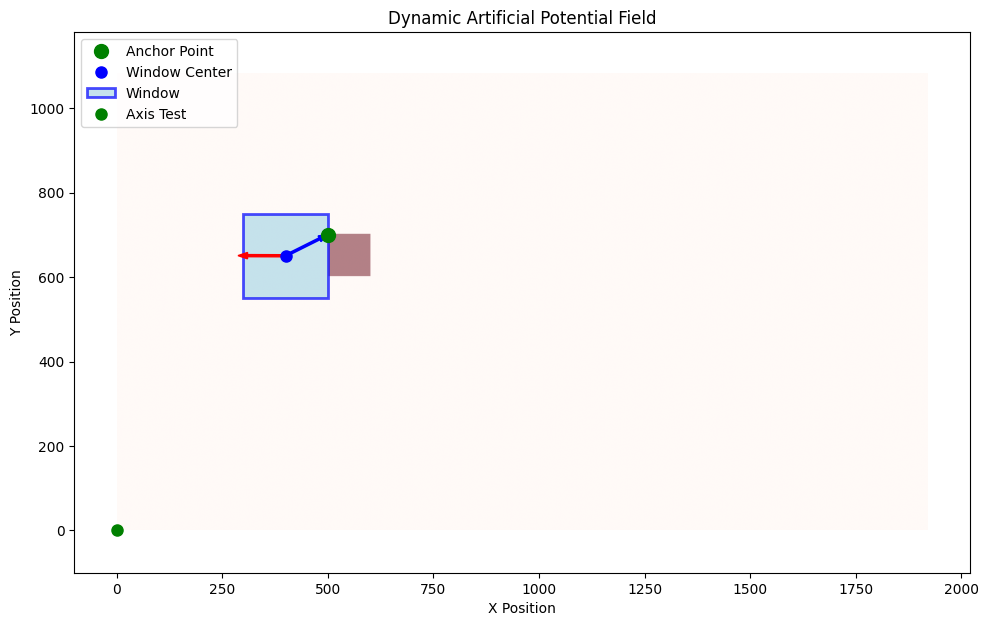

In [205]:
# 可视化的坐标轴好像有点问题
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlim(-100, view_width + 100)
ax.set_ylim(-100, view_height + 100)

ax.set_title('Dynamic Artificial Potential Field')

# 绘制静态元素
anchor_plot, = ax.plot(anchor_point[0], anchor_point[1], 'go', markersize=10, label='Anchor Point')
# obstacles_plot, = ax.plot(obstacles[:, 0], obstacles[:, 1], 'ro', markersize=8, label='Obstacles')

window_plot, = ax.plot(cur_pos[0], cur_pos[1], 'bo', markersize=8, label='Window Center')

# 绘制窗口
window_rect = patches.Rectangle(
    (cur_pos[0] - window_width/2, cur_pos[1] - window_height/2),
    window_width, window_height,
    linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.7, label='Window'
)
ax.add_patch(window_rect)

test_plot, = ax.plot([0], [0], 'go', markersize=8, label='Axis Test')

# 使用imshow绘制障碍物
obstacle_plot = ax.imshow(obstacle_mask.T, origin='lower', 
                          extent=[0, view_width, 0, view_height],
                          cmap='Reds', alpha=0.5)

# 绘制吸引力箭头测试
attractive_force_vis = attractive_force * 9
repulsive_force_vis = repulsive_force * 9
attractive_force_arraw = plt.arrow(cur_pos[0], cur_pos[1], attractive_force_vis[0], attractive_force_vis[1],
                         width=5, color='blue')
repulsive_force_arraw = plt.arrow(cur_pos[0], cur_pos[1], repulsive_force_vis[0], repulsive_force_vis[1],
                         width=5, color='red')


# 创建动画，需要重新调整可视化并封装图像的init和参数的update以传入，后续再调整
# ani = animation.FuncAnimation(fig, update, frames=2000, init_func=init, 
#                              blit=False, interval=50, repeat=False)

# 外围图例
ax.legend(loc='upper left')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

plt.tight_layout()
plt.show()

# Toy Setting

方便检验和可视化确认

In [206]:
# 临时变小检验值
view_width = 20
view_height = 10
d0 = 3

cur_pos = np.array([10, 5])
anchor_point = np.array([5, 8])

In [207]:
# 设置obstacle mask
obstacle_mask = np.zeros((view_width, view_height), dtype=bool)
obstacle_mask[6:8, 6:8] = True

df = pd.DataFrame(obstacle_mask)
df

,0,1,2,3,4,5,6,7,8,9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,True,True,False,False
7,False,False,False,False,False,False,True,True,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False
